In [31]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

In [40]:
# Load an image


#img = cv2.imread('../../images/1DJI0009.jpg')[:, :, ::-1]
img = cv2.imread('../../images/1DJI0005.jpg')[:, :, ::-1]

#img = cv2.resize(img, (2560, 1920))
img = cv2.resize(img, (1280, 960))

#img = img[64:269, 460:900]
img = img[320:588, 540:890]

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': True,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 1.3,
        'grad_nfa': False,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}


# Load the model
ckpt = '../weights/deeplsd_md.tar'

#ckpt = '../weights/deeplsd_wireframe.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

[[[109.57529  127.11366 ]
  [111.40489  150.04747 ]]

 [[128.40181   59.00004 ]
  [128.40428  165.99998 ]]

 [[117.114525 124.70514 ]
  [121.23391  154.24628 ]]

 [[ 29.896812 242.04178 ]
  [ 33.948143  58.086952]]

 [[ 11.283958 262.01505 ]
  [ 14.282089   6.015015]]]


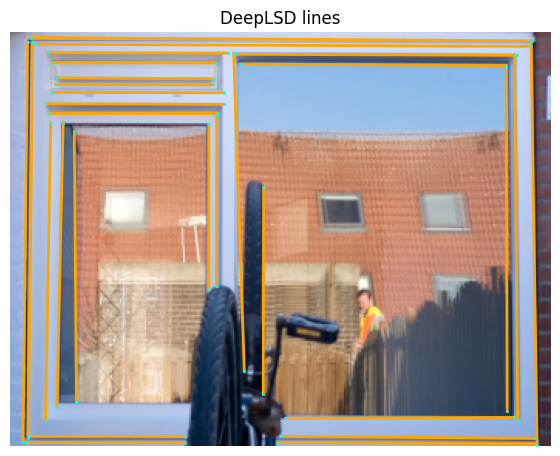

In [41]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]


print(pred_lines[:5])
def filter_lines(lines, min_length=10):
    """
    Filter out short lines
    """
    filtered_lst =  [line for line in lines if np.linalg.norm(line[0] - line[1]) >= min_length]
    return np.array(filtered_lst)

pred_lines_filtered = filter_lines(pred_lines, min_length=100)

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines_filtered], indices=range(1))

orig line:  [[  7.9750977 265.01102  ]
 [ 10.90291     5.9875994]] 2.0323124 3.37929 2.0323124
orig line:  [[ 13.00026     2.9603155]
 [337.01254     5.0842743]] 3.3127444 0.025635084 0.025635084
orig line:  [[  9.997938 265.207   ]
 [112.999344 265.38297 ]] 4.4343157 3.98755 3.98755
orig line:  [[337.01624     5.0589066]
 [340.89017   267.046    ]] 3.7559438 1.3834531 1.3834531
orig line:  [[173.00787 265.23694]
 [340.00455 265.98315]] 3.5074062 3.4892638 3.4892638


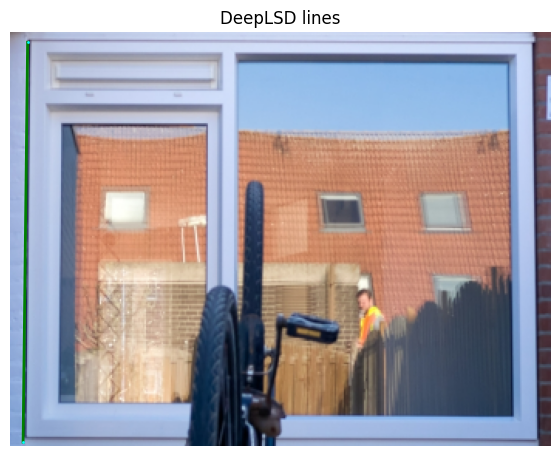

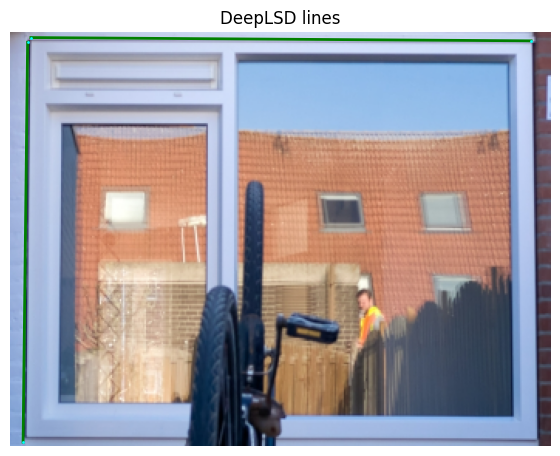

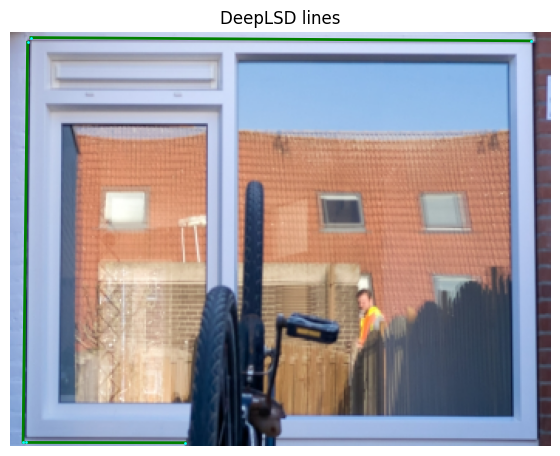

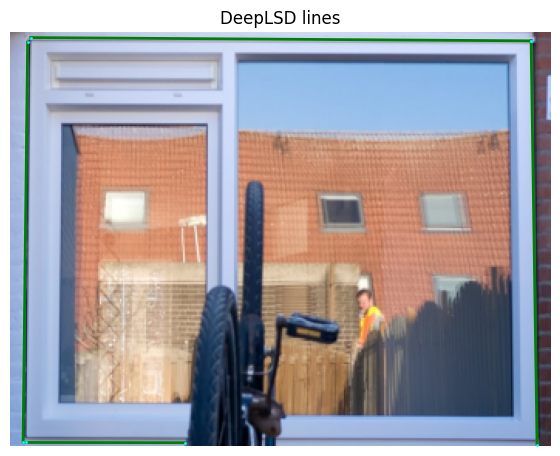

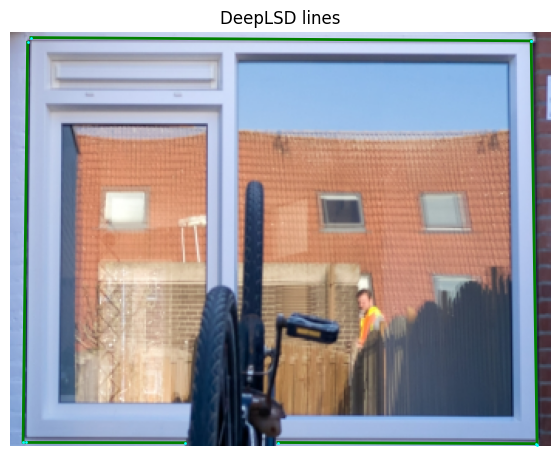

In [42]:
# line_arr has only long lines
# first arg of thresholds to make sure lines are not too small, second arg to make sure lines are connected
def get_square(line_arr, corner_pt, thresholds = [2.93]):
    # get the distance from corners for each line
    dist = np.sqrt(np.sum((line_arr.reshape(-1,2) - corner_pt)**2, axis=1))
    # get the index of the closest line and second closest line
    partitioned_indices = np.argpartition(dist, 2)[:2]
    closest = partitioned_indices[0]
    second_closest = partitioned_indices[1]

    # get the actual lines using unravel index
    closest_line = np.unravel_index(closest, line_arr.shape[:-1])
    second_closest_line = np.unravel_index(second_closest, line_arr.shape[:-1])

    # get the actual lines
    closest_line = line_arr[closest_line[0],:]
    second_closest_line = line_arr[second_closest_line[0],:]

    square_lst = []
    # put both in a queue
    queue = [closest_line, second_closest_line]
    
    line_arr = np.delete(line_arr, np.where((line_arr == closest_line).all(axis=1)), axis=0)
    line_arr = np.delete(line_arr, np.where((line_arr == second_closest_line).all(axis=1)), axis=0)

    while len(queue):
        # get the first element
        line = queue.pop(0)
        square_lst.append(line)

        plot_images([img], ['DeepLSD lines'], cmaps='gray')
        plot_lines([np.array(square_lst)], line_colors='green', indices=range(1))
        # save fig to file
        plt.savefig('square.png')

        # delete the line from the array
        line_arr = np.delete(line_arr, np.where((line_arr == line).all(axis=1)), axis=0)
        # get the distance from line to line_arr
        dist1 = np.sqrt(np.sum((line_arr.reshape(-1,2) - line[0])**2, axis=1))
        dist2 = np.sqrt(np.sum((line_arr.reshape(-1,2) - line[1])**2, axis=1))
        # get the indices of the lines that are close to the line

        #indices = np.where(dist < thresholds[0])
        smallest_dist_index1 = np.argmin(dist1)
        smallest_dist_index2 = np.argmin(dist2)
        # check if the distance is small enough

        dist = dist1 if dist1[smallest_dist_index1] < dist2[smallest_dist_index2] else dist2
        smallest_dist_index = smallest_dist_index1 if dist1[smallest_dist_index1] < dist2[smallest_dist_index2] else smallest_dist_index2

        print("orig line: ", line, dist1[smallest_dist_index1], dist2[smallest_dist_index2], dist[smallest_dist_index])

        if dist[smallest_dist_index] < thresholds[0]:
            # get the line that is closest
            line_index = np.unravel_index(smallest_dist_index, line_arr.shape[:-1])
            line = line_arr[line_index[0],:]
            # put the line in the queue
            queue.append(line)
        
    return np.array(square_lst)

pred_lines_copy = np.copy(pred_lines)

square_arr = get_square(pred_lines_copy, np.array([0, 0]))



In [35]:
square_arr.shape

(2, 2, 2)

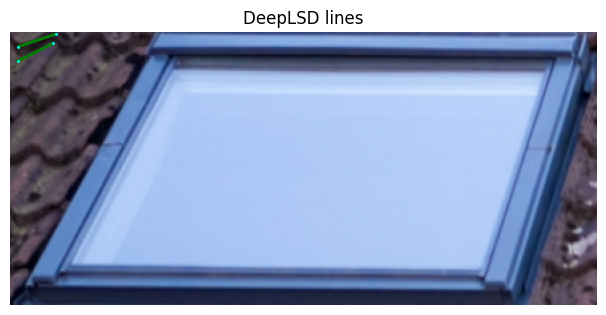

In [36]:
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([square_arr], line_colors='green', indices=range(1))